In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

np.random.seed(111)
%matplotlib inline
warnings.filterwarnings('ignore')

In [184]:
heart = pd.read_csv('heart.csv')
heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


# Machine Learning Phase

- Creating New Features, colored or not column. age ranges

In [185]:
def color(val):
    if val == 0:
        return 0
    return 1

heart['colored_or_no'] = heart['ca'].apply(color)

In [186]:
def categorize_ages(age):
    if age < 40:
        return 1
    elif age < 50:
        return 2
    elif age < 60:
        return 3
    elif age < 70:
        return 4
    else:
        return 5

# create a new column called "age_range"
heart['age_range'] = heart['age'].apply(categorize_ages)

- Scaling ['trestbps', 'age', 'chol', 'thalach'] columns as keeping their values will affect the models performances. 

In [187]:
from sklearn.preprocessing import StandardScaler
df = heart.copy()

cols = ['trestbps', 'age', 'chol', 'thalach']
for col in cols:
    scaler = StandardScaler()
    df[col] = scaler.fit_transform(df[[col]])
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,colored_or_no,age_range
0,0.952197,1,3,0.763956,-0.256334,1,0,0.015443,0,2.3,0,0,1,1,0,4
1,-1.915313,1,2,-0.092738,0.072199,0,1,1.633471,0,3.5,0,0,2,1,0,1
2,-1.474158,0,1,-0.092738,-0.816773,0,0,0.977514,0,1.4,2,0,2,1,0,2
3,0.180175,1,1,-0.663867,-0.198357,0,1,1.239897,0,0.8,2,0,2,1,0,3
4,0.290464,0,0,-0.663867,2.082050,0,1,0.583939,1,0.6,2,0,2,1,0,3


- We don't need to drop any of our columns as they don't represent Auto-Collinearity.

In [188]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df.drop(['target'], axis=1)

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                    for i in range(len(X.columns))]

vif_data.sort_values('VIF', ascending=False)

,feature,VIF
14,age_range,29.053480
12,thal,16.335789
10,slope,10.141662
13,colored_or_no,6.411725
11,ca,5.252106
0,age,3.742137
1,sex,3.649489
9,oldpeak,3.144529
2,cp,2.352358
6,restecg,2.127051


- We need to see the most correlated features to the target column.
    - (cp, thalach, slope, thal, ca, oldpeak, exang) are the top correlated columns.

In [189]:
df.corr()['target'].sort_values(ascending=False)

target           1.000000
cp               0.433798
thalach          0.421741
slope            0.345877
restecg          0.137230
fbs             -0.028046
chol            -0.085239
trestbps        -0.144931
age_range       -0.200609
age             -0.225439
sex             -0.280937
thal            -0.344029
ca              -0.391724
oldpeak         -0.430696
exang           -0.436757
colored_or_no   -0.465590
Name: target, dtype: float64

- There are some Outliers in our columns we will try to detect them Using The IQR method

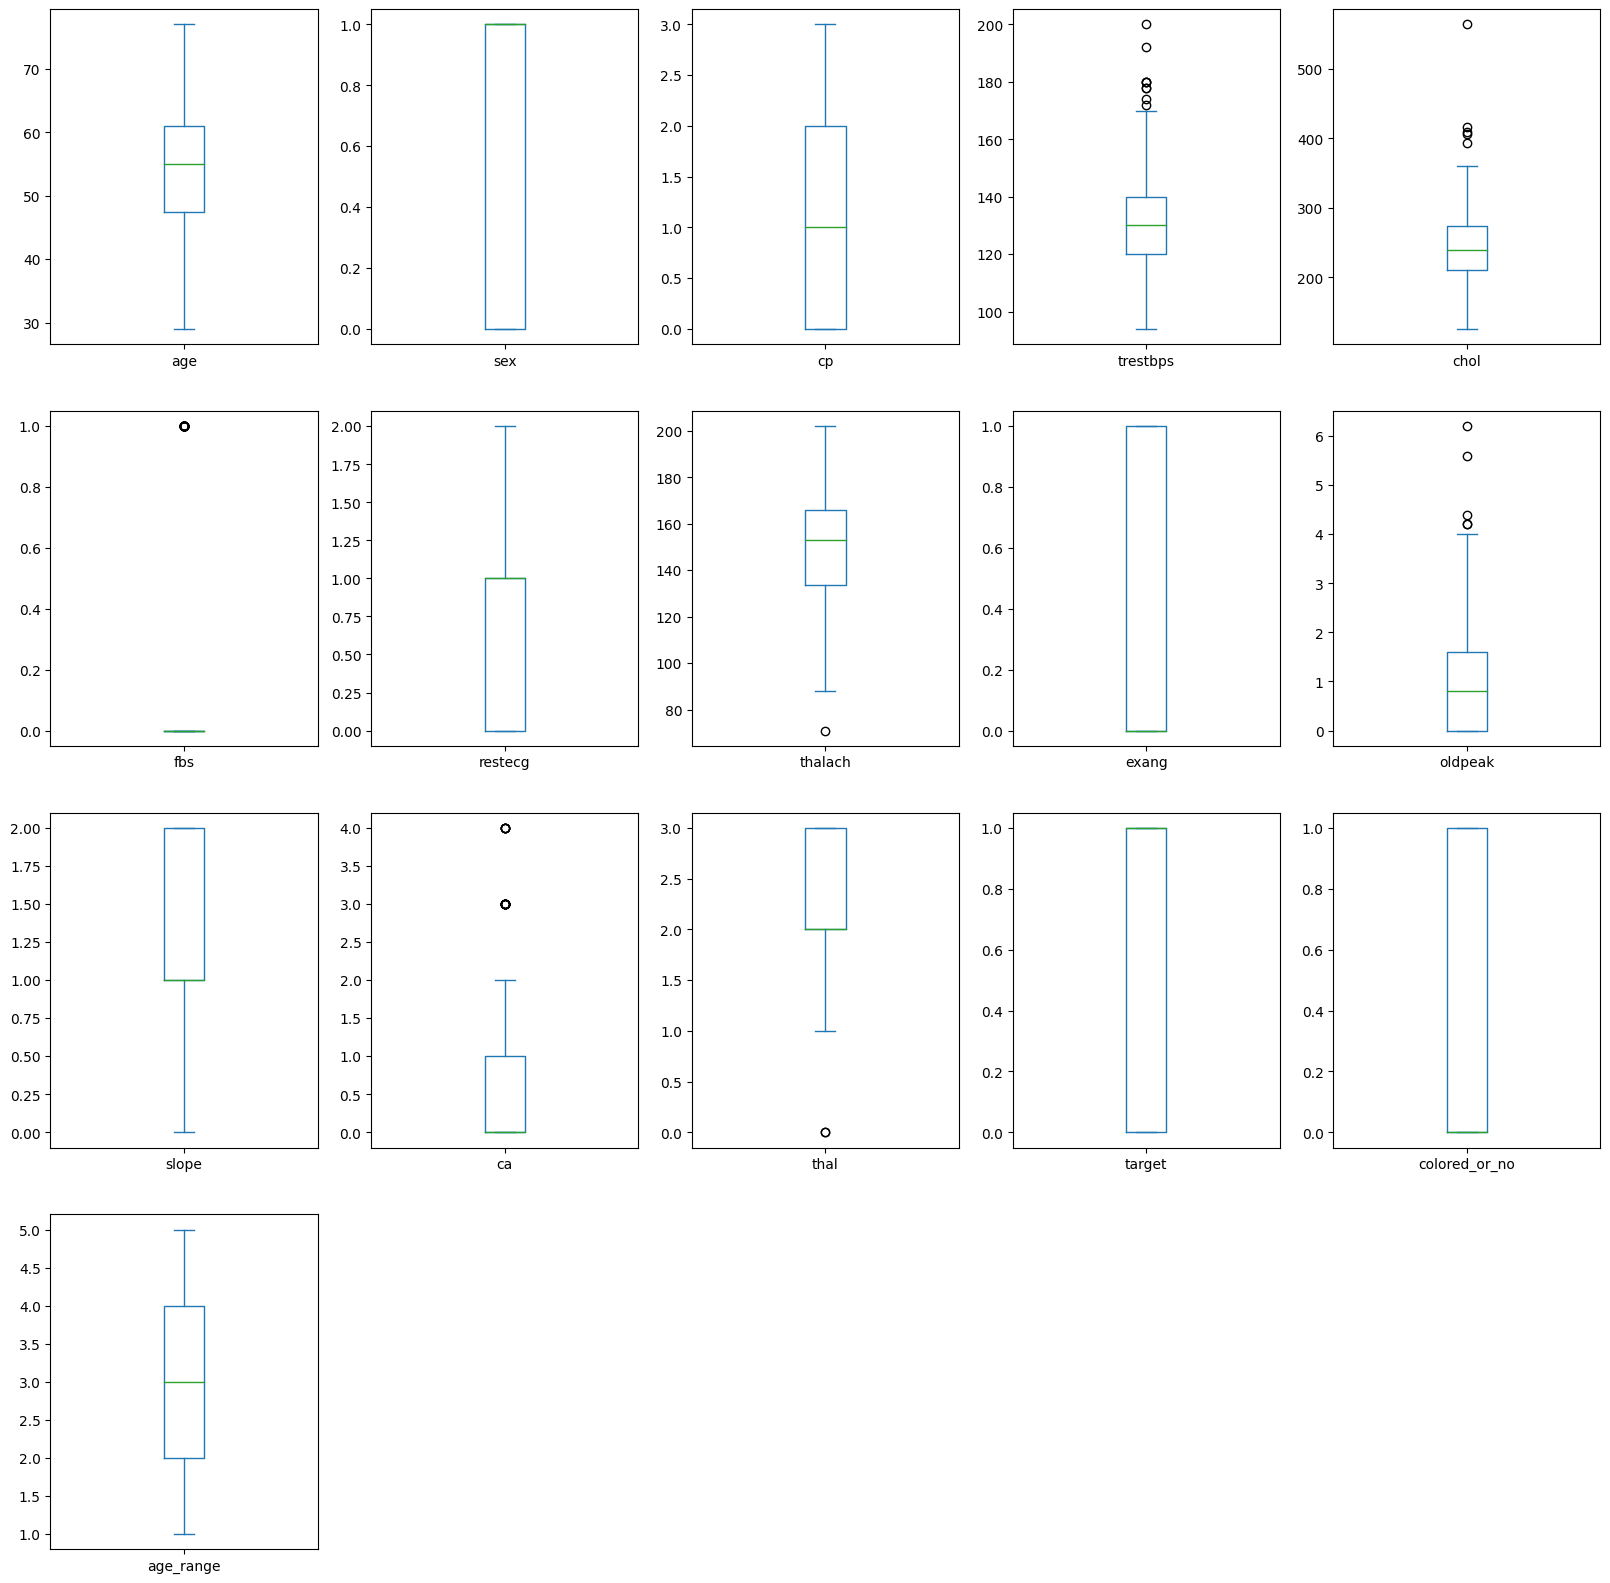

In [190]:
numerical_data = heart.select_dtypes(exclude='object')
numerical_data.plot(kind='box', subplots=True,\
                    sharex=False, sharey=False,\
                    figsize=(20, 20),  layout=(4, 5))

plt.savefig('figs/Box Plots.png', format='png')

#### Using the IQR(Inter Quartile Range) to identify outliers and Remove them.
- Calculating the Q1 and Q3 and IQR.
- Calculating the Lower_whisker and Upper_whisker.
- Getting the indecies of the outliers.
- Dropping the data points with those indecies . **(after some trials i found that dropping outliers of ca colunmn presents the highest accuracy results)**

In [191]:
def drop_outliers(col):
    q3, q1 = np.percentile(df[col], [75, 25])
    print(f'Shape before Dropping: {len(df)}')

    IQR = q3 - q1
    print('IQR:  ', IQR)

    upper_bound = q3 + 1.5 * IQR
    lower_bound = q1 - 1.5 * IQR

    mask1 = df[col] > upper_bound
    mask2 = df[col] < lower_bound

    outliers_indecies = df[(mask1) | (mask2)].index

    print(f'Number of Outliers:  {len(outliers_indecies)}')

    df.loc[outliers_indecies][col].value_counts()

    df.drop(outliers_indecies, inplace=True)
    print(f'Shape after Dropping Outliers: {df.shape[0]}')
    return df

df = drop_outliers('ca')

Shape before Dropping: 303
IQR:   1.0
Number of Outliers:  25
Shape after Dropping Outliers: 278


- Checking if the data is imbalanced.

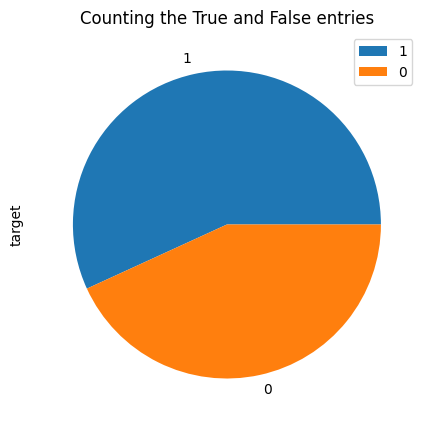

In [192]:
df['target'].value_counts().plot.pie(figsize=(10, 5))
plt.legend()
plt.title('Counting the True and False entries')
plt.savefig('figs/Counting the Yes and No entries.png', format='png')
plt.show()

- The data is almost Balanced so we don't need to do Random Over Sampling.
- Seperating the X and y variables.

In [193]:
# from imblearn.over_sampling import RandomOverSampler

X =  df.drop('target', axis=1)
y = df['target']

# rus = RandomOverSampler(sampling_strategy=1)
# X, y = rus.fit_resample(X, y)

### Model Comparison.
- The Logistic Regression Model presents the best result so i will go with it.
    - LDA 0.863 0.019
    - LogR 0.871 0.026 

Knn 0.798 0.052
svc 0.824 0.024
Dtc 0.773 0.08
Rdf 0.827 0.043
adb 0.78 0.071
grdb 0.773 0.054
Gaus 0.82 0.033
LDA 0.856 0.02
LogR 0.86 0.031
MLP 0.867 0.025


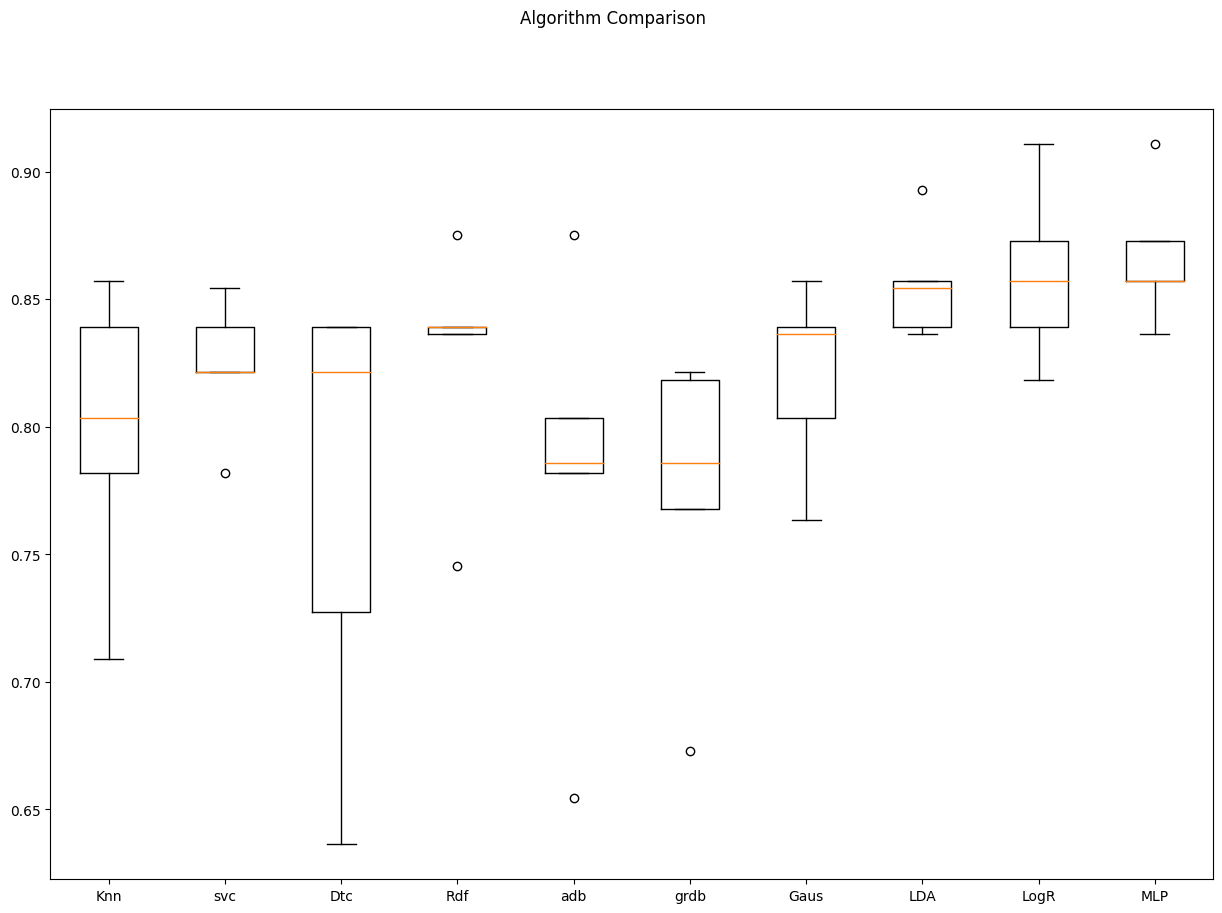

In [194]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, cross_val_score

models = [
    ('Knn', KNeighborsClassifier()),
    ('svc', SVC()),
    ('Dtc', DecisionTreeClassifier()),
    ('Rdf', RandomForestClassifier()),
	('adb', AdaBoostClassifier()),
    ('grdb', GradientBoostingClassifier()),
    ('Gaus', GaussianNB()),
    ('LDA', LinearDiscriminantAnalysis()),
    ('LogR', LogisticRegression(max_iter=1000)),
    ('MLP', MLPClassifier())
]
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = KFold(n_splits=5, random_state=0, shuffle=True)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(name, np.round(cv_results.mean(), 3), np.round(cv_results.std(), 3))
# boxplot algorithm comparison
fig = plt.figure(figsize=(15, 10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.savefig('figs/Models Comparison.png',  format='png')
plt.show()

In [195]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = MLPClassifier(alpha=0.001)

model.fit(X_train, y_train)
pred = model.predict(X_test)

In [196]:
from  sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Evaluating the model with the Classification Metrics

CM_RF = confusion_matrix(y_test, pred)
CR_RF = classification_report(y_test, pred)
fprRF, recallRF, thresholdsRF = roc_curve(y_test, pred)
AUC_RF = auc(fprRF, recallRF)

resultsRF = {"Confusion Matrix":CM_RF,"Classification Report":CR_RF,"Area Under Curve":AUC_RF}
# Showing the results of the model
for measure in resultsRF:
    print(measure,": \n", resultsRF[measure])

Confusion Matrix : 
 [[21  2]
 [ 2 31]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.91      0.91      0.91        23
           1       0.94      0.94      0.94        33

    accuracy                           0.93        56
   macro avg       0.93      0.93      0.93        56
weighted avg       0.93      0.93      0.93        56

Area Under Curve : 
 0.9262187088274045


In [197]:
import pickle
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [198]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.9285714285714286
